# Directional Coupler

Directional couplers are fundamental components in photonic integrated circuits, enabling efficient splitting and combining of optical signals. By placing two parallel waveguides in close proximity, these passive devices exploit evanescent field coupling to control how light is distributed between channels. It is also possible to control the output by adjusting the relative phase between the inputs, enabling flexible power splitting ratios and switching behavior. Their design and compatibility with silicon-on-insulator technology have made them a popular choice for applications ranging from wavelength-division multiplexing to optical switching and signal processing.

An important consideration is how fabrication variations might affect device performance. Hence, one common approach is to sweep over different parameters and see how the quantities of interest  behave.

In this notebook, we will demonstrate how to set up a simple directional coupler simulation, illustrating the common steps of the workflow:

[1](#1). Importing the geometry using [gdstk](https://heitzmann.github.io/gdstk/). For the process of this geometry, please follow the steps presented in [this](https://www.flexcompute.com/tidy3d/examples/notebooks/GDSCreation) example.

[2](#2). Placing the [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.html) and [ModeMonitors](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) to excite the first TE mode and  analyze the transmittance and losses on both arms

[3](#3). Carry out the post-process analysis to find the 50/50 splitting frequency and efficiency.

[4](#4). Create a parametric sweep over different values of the sidewall angle and its effect on the splitting frequency and efficiency, and create a [Batch](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.Batch.html) object to run in parallel.

[5](#5). Use the `Simulation.updated_copy` method to easily create a simulation with two sources at the input ports with a $\pi$/2 phase difference.

<img src="img/splitter.png" alt="Schematic of the directional coupler" width="400"/>

For instructions on how to calculate the full S-matrix, please refer to our [SMatrix](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.plugins.smatrix.Port.html) tutorial. Additionally, if you are new to the finite-difference time-domain (FDTD) method, we highly recommend going through our [FDTD101](https://www.flexcompute.com/fdtd101/) tutorials.

First, we import the relevant structures. We will use gdstk for importing the geometry. To install it, uncomment the `!pip install gdstk` line.

In [1]:
# install gdstk
#!pip install gdstk

# Standard python imports
import gdstk
import matplotlib.pyplot as plt
import numpy as np

# Tidy3d import
import tidy3d as td
from tidy3d import web

## Importing the Geometry <a name="1"></a>

We will use gdstk to import the geometry into a [Polyslab](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PolySlab.html) geometry, and extrude it along the z-direction (`axis=2`) with a given sidewall angle. For detailed instructions, please refer to [this](https://www.flexcompute.com/tidy3d/examples/notebooks/GDSImport) tutorial.

In [2]:
gds_path = "misc/coupler.gds"

# Load a GDSII library from the file previously created
lib_loaded = gdstk.read_gds(gds_path)
all_cells = {c.name: c for c in lib_loaded.cells}

# Define waveguide height
wg_height = 0.22
dilation = 0.02

# Define reference plane and sidewall angle
reference_plane = "bottom"
sidewall_angle = np.pi / 6

substrate_geo = td.Geometry.from_gds(
    all_cells["COUPLER"],
    gds_layer=0,
    gds_dtype=0,
    axis=2,
    slab_bounds=(-4, 0),
    reference_plane=reference_plane,
)

arms_geo = td.Geometry.from_gds(
    all_cells["COUPLER"],
    gds_layer=1,
    gds_dtype=0,
    axis=2,
    slab_bounds=(0, wg_height),
    sidewall_angle=sidewall_angle,
    dilation=dilation,
    reference_plane=reference_plane,
)

### Set up Structures

Next, we assign material properties to the imported geometries and create the [`td.Structures`](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/structures.html) with each of those material properties.

In [3]:
# Permittivity of waveguide and substrate
wg_n = 3.48
sub_n = 1.45
medium_wg = td.Medium(permittivity=wg_n**2)
medium_sub = td.Medium(permittivity=sub_n**2)

# Substrate
substrate = td.Structure(geometry=substrate_geo, medium=medium_sub)

# Waveguides
arms = td.Structure(geometry=arms_geo, medium=medium_wg)

structures = [substrate, arms]

## Set up Simulation <a name="2"></a>

Now we set up the simulation. First, we define the wavelength of interest and set the runtime.

In [4]:
# Wavelength range
wl1 = 1.4
wl2 = 1.7

# Transforming in frequency
f1 = td.C_0 / wl2
f2 = td.C_0 / wl1

fwidth = (f2 - f1) / 2
freq0 = f1 + fwidth
wl0 = td.C_0 / freq0

# Frequencies to analyze
num_freqs = 21
freqs = [freq0] if num_freqs == 1 else np.linspace(freq0 - fwidth, freq0 + fwidth, num_freqs)

Now, we add the [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.html), which excites the first order TE mode (`mode_index = 0`). To analyze the transmittance, we will place [ModeMonitors](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) at the end of both output arms. These monitors will carry out mode decomposition and analyze the fraction of power transmitted in each mode. Since we are only interested in the first order TE mode, the number of modes analyzed can be just 1.

We will also add a [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) to visualize the field profile in the xy-plane.

In [5]:
# Source
source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
source = td.ModeSource(
    center=(-8, -2, 0), size=(0, 2, 1), source_time=source_time, mode_index=0, direction="+"
)

# Field monitor
field_mon = td.FieldMonitor(
    name="field_mon",
    size=(td.inf, td.inf, 0),
    center=(0, 0, wg_height / 2),
    freqs=freqs,
)

# Mode monitor
mode_spec = td.ModeSpec(num_modes=1)
mode_mon_up = td.ModeMonitor(
    center=(8, 2, 0), size=(0, 2, 1), freqs=freqs, name="mode_mon_up", mode_spec=mode_spec
)

mode_mon_down = td.ModeMonitor(
    center=(8, -2, 0), size=mode_mon_up.size, freqs=freqs, name="mode_mon_down", mode_spec=mode_spec
)

Finally, we define the grid with our [AutoGrid](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.AutoGrid.html) object, which  automatically creates a non-uniform mesh, and place everything together in the [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) object.

In [6]:
# GridSpec
min_steps_per_wvl = 15
grid_spec = td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl)

# Simulation size
sim_size = (17, 7, wg_height + 2)
sim_center = list(arms_geo.bounding_box.center)
sim_center[2] = 0

### Initialize and visualize simulation ###
sim = td.Simulation(
    size=sim_size,
    center=sim_center,
    grid_spec=grid_spec,
    structures=structures,
    run_time=5e-12,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    sources=[source],
    monitors=[field_mon, mode_mon_up, mode_mon_down],
)

### Plot Simulation Geometry

It is a good practice to check the simulation and see if everything is correctly set. That can be easily achieved with the `Simulation.plot` method:

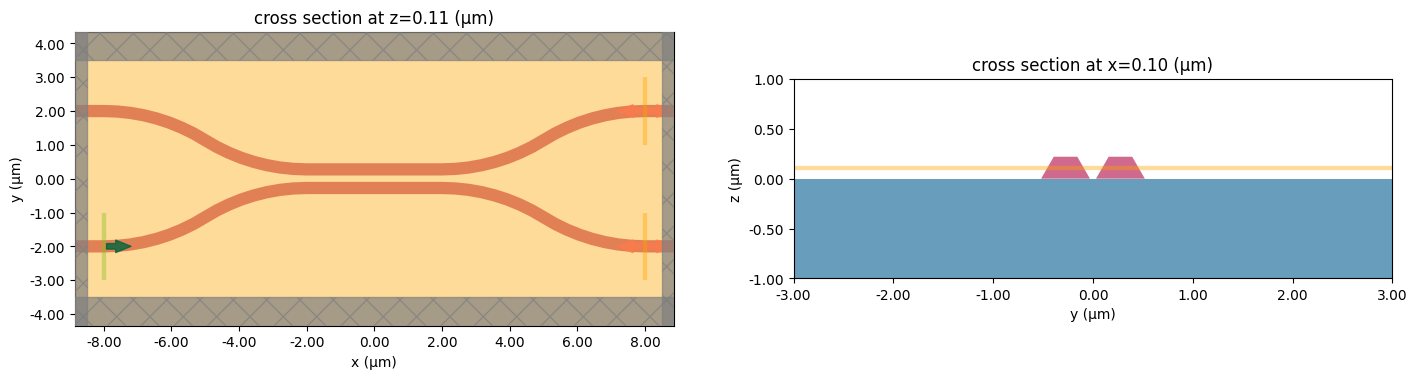

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17, 5))

sim.plot(z=wg_height / 2, lw=1, ax=ax1)
sim.plot(x=0.1, lw=1, ax=ax2)

ax2.set_xlim([-3, 3])
_ = ax2.set_ylim([-1, 1])

plt.show()

We can also see the 3D model.

In [8]:
sim.plot_3d()

Before running the simulation, we can check the **maximum** possible Flexcredit cost. If the field decays before the runtime, the simulation will auto shut-off and we will only be billed for the Flexcredits of the effective runtime.

In [9]:
# Estimating the cost
task_id = web.upload(sim, "directional coupler")
cost = web.estimate_cost(task_id)

20:00:20 CEST Created task 'directional coupler' with task_id                   
              'fdve-a94ff755-eefa-4878-bb01-448c406f37ad' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=769795;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a94ff755-eefa-4878-bb01-448c406f37ad\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=444563;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a94ff755-eefa-4878-bb01-448c406f37ad\taskId]8;;\]8;id=769795;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a94ff755-eefa-4878-bb01-448c406f37ad\=]8;;\]8;id=948906;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a94ff755-eefa-4878-bb01-448c406f37ad\fdve]8;;\]8;id=769795;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a94ff755-eefa-4878-bb01-448c406f37ad\-a94ff755-ee]8;;\
              ]8;id=769795;https://tidy3d.simulation.cloud/workbench?taskId=fdve-a94ff755-eefa-4878-bb01-448c406f37ad\fa-4878-bb01-448c406f37ad']8;;\.

              Task folder: ]8;id=791292;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

20:00:22 CEST Maximum FlexCredit cost: 0.241. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

20:00:23 CEST Maximum FlexCredit cost: 0.241. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

Finally, we can run the simulation and analyze the data.

In [10]:
sim_data = web.run(sim, "directional coupler")

              Created task 'directional coupler' with task_id                   
              'fdve-20eb56d6-214e-4dc7-a18e-e313fef9f20b' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=9405;https://tidy3d.simulation.cloud/workbench?taskId=fdve-20eb56d6-214e-4dc7-a18e-e313fef9f20b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=522464;https://tidy3d.simulation.cloud/workbench?taskId=fdve-20eb56d6-214e-4dc7-a18e-e313fef9f20b\taskId]8;;\]8;id=9405;https://tidy3d.simulation.cloud/workbench?taskId=fdve-20eb56d6-214e-4dc7-a18e-e313fef9f20b\=]8;;\]8;id=461831;https://tidy3d.simulation.cloud/workbench?taskId=fdve-20eb56d6-214e-4dc7-a18e-e313fef9f20b\fdve]8;;\]8;id=9405;https://tidy3d.simulation.cloud/workbench?taskId=fdve-20eb56d6-214e-4dc7-a18e-e313fef9f20b\-20eb56d6-21]8;;\
              ]8;id=9405;https://tidy3d.simulation.cloud/workbench?taskId=fdve-20eb56d6-214e-4dc7-a18e-e313fef9f20b\4e-4dc7-a18e-e313fef9f20b']8;;\.

              Task folder: ]8;id=525088;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

20:00:25 CEST Maximum FlexCredit cost: 0.241. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

20:00:26 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

20:02:48 CEST starting up solver

              running solver

Output()

20:03:12 CEST early shutoff detected at 12%, exiting.

              status = postprocess

Output()

20:03:21 CEST status = success

20:03:23 CEST View simulation result at                                         
              ]8;id=33865;https://tidy3d.simulation.cloud/workbench?taskId=fdve-20eb56d6-214e-4dc7-a18e-e313fef9f20b\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=576396;https://tidy3d.simulation.cloud/workbench?taskId=fdve-20eb56d6-214e-4dc7-a18e-e313fef9f20b\taskId]8;;\]8;id=33865;https://tidy3d.simulation.cloud/workbench?taskId=fdve-20eb56d6-214e-4dc7-a18e-e313fef9f20b\=]8;;\]8;id=706192;https://tidy3d.simulation.cloud/workbench?taskId=fdve-20eb56d6-214e-4dc7-a18e-e313fef9f20b\fdve]8;;\]8;id=33865;https://tidy3d.simulation.cloud/workbench?taskId=fdve-20eb56d6-214e-4dc7-a18e-e313fef9f20b\-20eb56d6-21]8;;\
              ]8;id=33865;https://tidy3d.simulation.cloud/workbench?taskId=fdve-20eb56d6-214e-4dc7-a18e-e313fef9f20b\4e-4dc7-a18e-e313fef9f20b']8;;\.

Output()

20:03:27 CEST loading simulation from simulation_data.hdf5

##  Postprocessing <a name="3"></a>

Now we would like to analyze the output of each arm as a function of wavelength, and find the frequency where the fields are equally distributed, and the losses.

The monitor decomposes the fields into mode components, and since the source is [normalized](https://docs.flexcompute.com/projects/tidy3d/en/latest/faq/docs/faq/How-are-results-normalized.html), the transmittance of each component is simply $\text{|amplitude|}^2$.

For finding the point where the amplitudes of each arm are the same, we will just look at the signal change of the difference between both signals, which is the crossing point. For better resolution, we will interpolate the data.

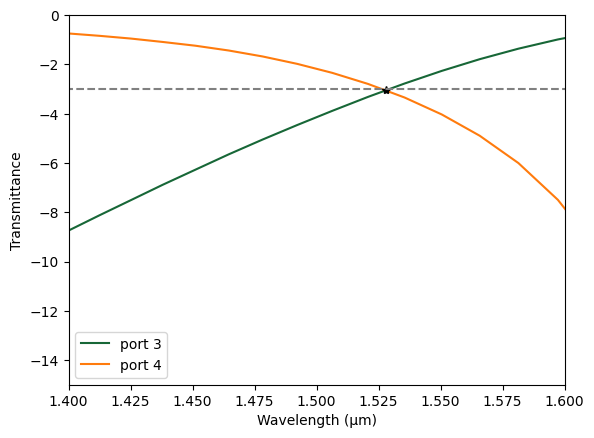

Crossing wavelength :1.53
Total transmittance: 0.9912


In [11]:
from scipy.interpolate import interp1d


def postprocess(sim_data, plot=True):
    transmission_up = sim_data["mode_mon_up"].amps.sel(mode_index=0, direction="+").abs ** 2
    transmission_down = sim_data["mode_mon_down"].amps.sel(mode_index=0, direction="+").abs ** 2
    freqs = transmission_up.f.values

    diff = (transmission_up - transmission_down).values

    # Interpolate difference to find zero crossing (sign change)
    sign_change = np.where(np.diff(np.sign(diff)))[0]
    if len(sign_change) == 0:
        crossing_freq = freqs[np.argmin(abs(diff))]
        print("No sign change found, showing closest point only.")
    else:
        i = sign_change[0]
        f_interp = interp1d(diff[i : i + 2], freqs[i : i + 2])
        crossing_freq = f_interp(0)
    amp_crossing = np.interp(crossing_freq, freqs, transmission_up)
    if plot:
        fig, ax = plt.subplots()

        wavelengths = td.C_0 / freqs
        ax.plot(wavelengths, 10 * np.log10(transmission_up), label="port 3")
        ax.plot(wavelengths, 10 * np.log10(transmission_down), label="port 4")

        ax.plot([td.C_0 / crossing_freq], [10 * np.log10(amp_crossing)], "*", color="black")

        ax.set_ylabel("Transmittance")
        ax.set_xlabel("Wavelength (µm)")
        ax.hlines(-3.01, 1, 1.6, colors="gray", linestyles="dashed")
        ax.set_xlim(1.4, 1.6)
        ax.set_ylim(-15, 0)
        ax.legend()

        plt.show()
    return float(crossing_freq), 2 * amp_crossing


cross_freq, total_transmittance = postprocess(sim_data)

print(f"Crossing wavelength :{td.C_0 / cross_freq:.2f}")
print(f"Total transmittance: {total_transmittance:.4f}")

Now, we can easily plot the E field with the `SimulationData.plot_field` method. As we can see, the input field is equally split over the two output arms.

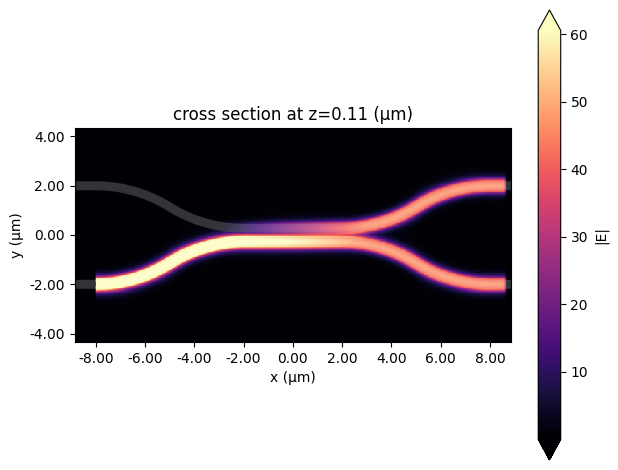

In [12]:
# Plot field
sim_data.plot_field("field_mon", "E", "abs", f=cross_freq)

plt.show()

## Parametric Sweep <a name="4"></a>

Now, we will investigate how the sidewall angle changes the component performance. To do so, we will create a dictionary where each value is a simulation object with a different coupler sidewall.

In [13]:
sims = {}
sidewall_angles = [0, 5, 10, 15, 20, 25, 30]
for s_angle in sidewall_angles:
    arms_geo_sweep = td.Geometry.from_gds(
        all_cells["COUPLER"],
        gds_layer=1,
        gds_dtype=0,
        axis=2,
        slab_bounds=(0, wg_height),
        sidewall_angle=np.deg2rad(s_angle),
        dilation=dilation,
        reference_plane=reference_plane,
    )

    arms_sweep = td.Structure(geometry=arms_geo_sweep, medium=medium_wg)
    sims[s_angle] = sim.updated_copy(structures=[substrate, arms_sweep])

Next, we create a [Batch](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.Batch.html) object to run all simulations in parallel.

In [14]:
batch = web.Batch(simulations=sims, folder_name="directional_coupler")
batch_data = batch.run()

Output()

20:03:31 CEST Started working on Batch containing 7 tasks.

20:03:38 CEST Maximum FlexCredit cost: 1.686 for the whole batch.

              Use 'Batch.real_cost()' to get the billed FlexCredit cost after   
              the Batch has completed.

Output()

20:20:28 CEST Batch complete.

Output()

Now we can easily track the crossing frequency and transmittance using our defined post-processing function.

In [15]:
freqs = []
transmittance = []
for data in batch_data.values():
    f, t = postprocess(data, plot=False)
    freqs.append(f)
    transmittance.append(t)

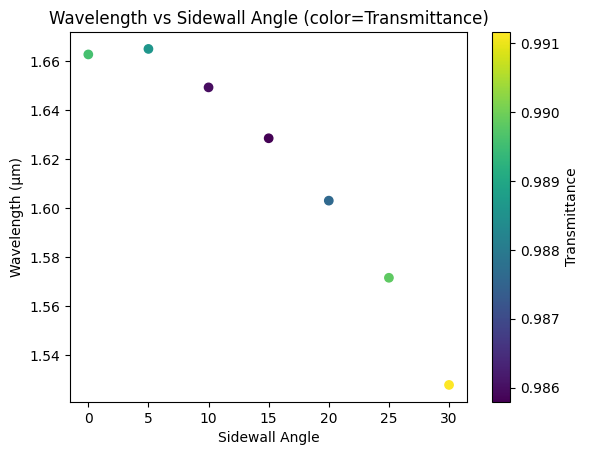

In [16]:
fig, ax = plt.subplots()

# Use scatter for color mapping
sc = ax.scatter(sidewall_angles, td.C_0 / np.array(freqs), c=transmittance, cmap="viridis")
plt.colorbar(sc, ax=ax, label="Transmittance")

ax.set_xlabel("Sidewall Angle")
ax.set_ylabel("Wavelength (µm)")
ax.set_title("Wavelength vs Sidewall Angle (color=Transmittance)")

plt.show()

## Creating a Simulation With Two Ports <a name="5"></a>

We can use the `updated_copy` method to easily create another simulation with a second source with a $\pi$/2 phase difference.

In [17]:
source_time2 = source_time.updated_copy(phase=np.pi / 2)
source2 = source.updated_copy(
    center=(source.center[0], -source.center[1], source.center[2]), source_time=source_time2
)

sim2 = sim.updated_copy(sources=[source, source2])

sim_data2 = web.run(sim2, "sources at 1 and 2")

20:21:18 CEST Created task 'sources at 1 and 2' with task_id                    
              'fdve-67ee4456-c637-4853-9b43-3992708a06bb' and task_type 'FDTD'.

              View task using web UI at                                         
              ]8;id=906064;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67ee4456-c637-4853-9b43-3992708a06bb\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=509281;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67ee4456-c637-4853-9b43-3992708a06bb\taskId]8;;\]8;id=906064;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67ee4456-c637-4853-9b43-3992708a06bb\=]8;;\]8;id=566449;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67ee4456-c637-4853-9b43-3992708a06bb\fdve]8;;\]8;id=906064;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67ee4456-c637-4853-9b43-3992708a06bb\-67ee4456-c6]8;;\
              ]8;id=906064;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67ee4456-c637-4853-9b43-3992708a06bb\37-4853-9b43-3992708a06bb']8;;\.

              Task folder: ]8;id=3002;https://tidy3d.simulation.cloud/folders/folder-7a0ee478-ee62-43e0-9a9e-26a06b299b0a\'default']8;;\.

Output()

20:21:20 CEST Maximum FlexCredit cost: 0.245. Minimum cost depends on task      
              execution details. Use 'web.real_cost(task_id)' to get the billed 
              FlexCredit cost after a simulation run.

20:21:21 CEST status = queued

              To cancel the simulation, use 'web.abort(task_id)' or             
              'web.delete(task_id)' or abort/delete the task in the web UI.     
              Terminating the Python script will not stop the job running on the
              cloud.

Output()

20:28:35 CEST status = preprocess

20:28:39 CEST starting up solver

20:28:40 CEST running solver

Output()

20:28:50 CEST early shutoff detected at 12%, exiting.

              status = postprocess

Output()

20:28:55 CEST status = success

20:28:57 CEST View simulation result at                                         
              ]8;id=345288;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67ee4456-c637-4853-9b43-3992708a06bb\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=947860;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67ee4456-c637-4853-9b43-3992708a06bb\taskId]8;;\]8;id=345288;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67ee4456-c637-4853-9b43-3992708a06bb\=]8;;\]8;id=2773;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67ee4456-c637-4853-9b43-3992708a06bb\fdve]8;;\]8;id=345288;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67ee4456-c637-4853-9b43-3992708a06bb\-67ee4456-c6]8;;\
              ]8;id=345288;https://tidy3d.simulation.cloud/workbench?taskId=fdve-67ee4456-c637-4853-9b43-3992708a06bb\37-4853-9b43-3992708a06bb']8;;\.

Output()

20:29:01 CEST loading simulation from simulation_data.hdf5

As we can see, in this configuration, all power is directed to the upper output at the crossing frequency.

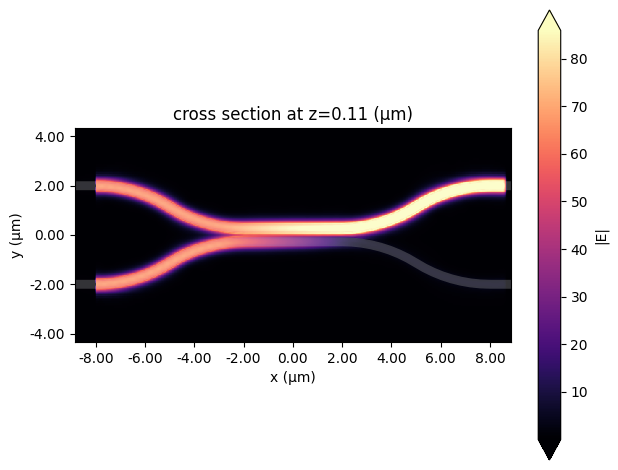

In [18]:
# Plot field
sim_data2.plot_field("field_mon", "E", "abs", f=cross_freq)

plt.show()